# Set up
## Check Environment

In [2]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [3]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)
print(bucket)

sagemaker-us-east-1-458903497716


In [4]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [5]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from tqdm import tqdm  
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

# Import Data
## Copy Data from public S3 Bucket

In [66]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/modeling"
print(s3_public_path)

s3://sagemaker-studio-458903497716-h2kl4ff3dz/modeling


In [68]:
s3_private_path = "s3://{}/data_for_eda".format(bucket)

print(s3_private_path)


s3://sagemaker-us-east-1-458903497716/data_for_eda


In [80]:
!aws s3 cp --recursive $s3_public_path/data_for_eda.csv $s3_private_path/ --include "*" 

# Create Database Schema in Athena

In [74]:
sess = sagemaker.Session()
bucket = '{}'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-458903497716'

In [75]:
# Assign database name
database_name = "ads508"

In [76]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [77]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [78]:
# Create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [79]:
# Verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws
3,sagemaker_featurestore


In [17]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}/EDA".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-458903497716/EDA


In [18]:
drop="DROP TABLE ads508.gun_violence"
query=pd.read_sql(drop,conn)

In [19]:
# Import the main dataset w/ all newly created attributes

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        id int,
        incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int,
         target_class int,
         n_total int,
         region string,
         year int,
         group_Democrat int,
         group_Republican int,
         suspect_age int,
         suspect_age_value int,
         suspect_rel string,
         suspect_age_group string
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [20]:
table_name_csv_1 = "est2018"
s3_path_1 = "s3://{}/census2010_data".format(bucket)
print(s3_path_1)

s3://sagemaker-us-east-1-458903497716/census2010_data


In [21]:
# Supplementary dataset -- 2010 census state population

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    sumlev int,
    state int,
    county int,
    place int,
    cousub int,
    concit int,
    primgeo_flag int,
    funcstat int,
    name string,
    stname string,
    census2010pop int,
    estimatesbase2010 int,
    popestimates2010 int,
    popestimates2011 int,
    popestimates2012 int,
    popestimates2013 int,
    popestimates2014 int,
    popestimates2015 int,
    popestimates2016 int,
    popestimates2017 int,
    popestimates2018 int
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_1, s3_path_1
)

create_table_1 = pd.read_sql(statement, conn)
create_table_1

""


In [22]:
table_name_csv_2 = "state_abbrev"
s3_path_2 = "s3://{}/state_abbrev_data".format(bucket)
print(s3_path_2)

s3://sagemaker-us-east-1-458903497716/state_abbrev_data


In [23]:
# Supplementary dataset -- state abbreviations

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
   state string,
   abbrev string,
   code string
         
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_2, s3_path_2
)

create_table_2 = pd.read_sql(statement, conn)
create_table_2

""


In [24]:
table_name_csv_3 = "congress_2013_to_2018"
s3_path_3 = "s3://{}/congress_data".format(bucket)
print(s3_path_3)

s3://sagemaker-us-east-1-458903497716/congress_data


In [25]:
# Supplementary dataset -- 2013-2018 congressional data 

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
 id string,
 name string,
 sort_name string,
 email string,
 twitter string,
 facebook string,
 group string,
 group_id string,
 state string,
 district int,
 chamber string,
 year int,
 start_date date,
 end_date date,
 image string,
 gender string,
 wikidata string,
 wikidata_group string,
 wikidata_area string
 
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_3, s3_path_3
)

create_table_3 = pd.read_sql(statement, conn)
create_table_3

""


In [26]:
table_name_csv_4 = "state_income"
s3_path_4 = "s3://{}/state_income_data".format(bucket)
print(s3_path_4)

s3://sagemaker-us-east-1-458903497716/state_income_data


In [27]:
# Supplementary dataset -- state income

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
 id int,
 zipcode int,
 agi int,
 avg_agi int,
 groups string,
 avg_income int
 
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_4, s3_path_4
)

create_table_4 = pd.read_sql(statement, conn)
create_table_4

""


In [28]:
table_name_csv_5 = "cities"
s3_path_5 = "s3://{}/cities_data".format(bucket)
print(s3_path_5)

s3://sagemaker-us-east-1-458903497716/cities_data


In [29]:
# Supplementary dataset -- city coordinates

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    city string,
    city_ascii string,
    state_id string,
    state_name string,
    county_fips int,
    county_name string,
    lat string,
    lng string,
    population string,
    density string,
    source string,
    military string,
    incorporated string,
    timezone string,
    ranking int,
    zips string,
    id int)
    
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
WITH SERDEPROPERTIES ( 
  'quoteChar'='\"', 
  'separatorChar'=',') 
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_5, s3_path_5
)

create_table_5 = pd.read_sql(statement, conn)
create_table_5

""


In [30]:
# Show all tables
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,cities
1,congress_2013_to_2018
2,est2018
3,gun_violence
4,state_abbrev
5,state_income


In [31]:
statement = "SELECT * from ads508.est2018 LIMIT 100"
df_pop = pd.read_sql(statement, conn)
df_pop.head(5)

,sumlev,state,county,place,cousub,concit,primgeo_flag,funcstat,name,stname,...,estimatesbase2010,popestimates2010,popestimates2011,popestimates2012,popestimates2013,popestimates2014,popestimates2015,popestimates2016,popestimates2017,popestimates2018
0,40,1,0,0,0,0,0,None,Alabama,Alabama,...,4780138,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,162,1,0,124,0,0,0,None,Abbeville city,Alabama,...,2688,2684,2677,2629,2612,2595,2588,2573,2566,2563
2,162,1,0,460,0,0,0,None,Adamsville city,Alabama,...,4516,4510,4496,4474,4453,4432,4406,4373,4342,4325
3,162,1,0,484,0,0,0,None,Addison town,Alabama,...,754,751,751,744,743,740,735,734,728,724
4,162,1,0,676,0,0,0,None,Akron town,Alabama,...,356,355,345,345,341,339,337,332,332,330


In [32]:
statement = "SELECT * from ads508.congress_2013_to_2018 LIMIT 100"
df_cong = pd.read_sql(statement, conn)
df_cong.head(5)

,id,name,sort_name,email,twitter,facebook,group,group_id,state,district,chamber,year,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area
0,cfc9cc09-a33a-42d9-89c3-14effb20b8b0,Aaron Schock,"""Schock","Aaron""",,AaronSchock,RepAaronSchock,Republican,republican,None,18,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q302659,Q29468
1,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"""Schiff","Adam""",,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,None,28,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552
2,159bbcc4-afee-4a5d-9097-e2be4d8ca9c7,Adam Kinzinger,"""Kinzinger","Adam""",,RepKinzinger,RepKinzinger,Republican,republican,None,16,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q349955,Q29468
3,fed6fe02-7935-4711-a190-fed9abd0a5ae,Adam Smith,"""Smith","Adam""",,RepAdamSmith,RepAdamSmith,Democrat,democrat,None,9,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q350916,Q29552
4,4eb41831-ea19-4833-86f9-6f6c3ba72451,Adrian Smith,"""Smith","Adrian""",,RepAdrianSmith,,Republican,republican,None,3,NaN,None,None,,https://theunitedstates.io/images/congress/ori...,male,Q373443,Q29468


In [33]:
statement = "SELECT * from ads508.state_abbrev LIMIT 100"
df_abbrev = pd.read_sql(statement, conn)
df_abbrev.head(5)

,state,abbrev,code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [34]:
statement = "SELECT * from ads508.state_income LIMIT 100"
df_income = pd.read_sql(statement, conn)
df_income.head(5)

,id,zipcode,agi,avg_agi,groups,avg_income
0,0,0,0,None,,NaN
1,1,35004,255534,None,Middle,113845.0
2,2,35005,128387,None,Middle,113845.0
3,3,35006,58302,None,Middle,113845.0
4,4,35007,643708,None,Upper,594096.0


In [35]:
statement = "SELECT * from ads508.cities LIMIT 100"
df_cities = pd.read_sql(statement, conn)
df_cities.head(5)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18972871,10768.2,shape,FALSE,TRUE,America/New_York,1,11229 11226 11225 11224 11223 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12121244,3267.6,shape,FALSE,TRUE,America/Los_Angeles,1,90291 90293 90292 91316 91311 90035 90034 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8595181,4576.6,shape,FALSE,TRUE,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,5711945,4945.7,shape,FALSE,TRUE,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5668165,1522.2,shape,FALSE,TRUE,America/Chicago,1,75287 75098 75234 75254 75251 75252 75253 7503...,1840019440


In [36]:
# Read in gun_violence data w/ all created attributes 
# Note: Must run Data_Preparation.csv prior

%store -r df
df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,target_class,n_total,region,year,group_Democrat,group_Republican,suspect_age,suspect_age_value,suspect_rel,suspect_age_group
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,1,4,Middle Atlantic,2013,1,0,Adult 18+,30.3408,,Mid-Adult
1,481268,2013-10-21,Pennsylvania,Pittsburgh (Homewood),7200 block of Kelly Street,2,5,http://www.gunviolencearchive.org/incident/481268,http://www.wtae.com/news/local/allegheny/two-p...,False,...,1,7,Middle Atlantic,2013,1,0,,30.3408,,Mid-Adult
2,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,1,4,Pacific,2013,1,0,,30.3408,,Mid-Adult
3,486109,2013-05-10,California,Los Angeles,1600 block of West 205th Street,3,1,http://www.gunviolencearchive.org/incident/486109,http://articles.latimes.com/2013/may/10/local/...,False,...,1,4,Pacific,2013,1,0,Adult 18+,30.3408,,Mid-Adult
4,492950,2013-11-03,California,Los Angeles,1 World Way,1,3,http://www.gunviolencearchive.org/incident/492950,https://www.lawa.org/uploadedFiles/LAX/LAWA%20...,False,...,1,4,Pacific,2013,1,0,,30.3408,,Mid-Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220341,1062176,2018-03-04,New Jersey,Jackson,920 W Veterans Hwy,1,0,http://www.gunviolencearchive.org/incident/106...,https://www.rlsmedia.com/article/developing-ja...,False,...,1,1,Middle Atlantic,2018,0,1,,30.3408,,Mid-Adult
220342,1065941,2018-03-09,New Jersey,Ocean (county),NaN,0,0,http://www.gunviolencearchive.org/incident/106...,http://www.nj.com/ocean/index.ssf/2018/03/mass...,False,...,0,0,Middle Atlantic,2018,0,1,Adult 18+,46.0000,,Adult
220343,1066210,2018-03-06,New York,Bronx,3049 Buhre Ave,0,0,http://www.gunviolencearchive.org/incident/106...,http://bronxvoice.com/bad-shot/,False,...,0,0,Middle Atlantic,2018,1,0,,30.3408,,Mid-Adult
220344,1072748,2018-03-15,New York,Corona (Queens),NaN,0,0,http://www.gunviolencearchive.org/incident/107...,http://queenspress.com/101st-precinct-gang-mem...,False,...,0,0,Middle Atlantic,2018,1,0,Adult 18+,25.0000,,Young Adult


In [37]:
statement="SELECT * FROM ads508.gun_violence LIMIT 10"
query = pd.read_sql(statement,conn)
query

,id,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,...,target_class,n_total,region,year,group_democrat,group_republican,suspect_age,suspect_age_value,suspect_rel,suspect_age_group
0,51854,392873,2015-08-12,Illinois,Chicago,5100 block of South Indiana,0,2,http://www.gunviolencearchive.org/incident/392873,http://chicago.suntimes.com/crime/7/71/871981/...,...,5.0,3.0,1,2.0,NaN,2015,1.0,0.0,,30.34079961156613
1,51855,392767,2015-08-12,Illinois,Chicago,400 block of West Evergreen Avenue,0,1,http://www.gunviolencearchive.org/incident/392767,http://www.dnainfo.com/chicago/20150812/old-to...,...,5.0,1.0,1,NaN,2015.0,1,0.0,NaN,30.34079961156613,
2,51856,393601,2015-08-12,Illinois,Chicago,400 block of West West End Avenue,0,2,http://www.gunviolencearchive.org/incident/393601,http://www.dnainfo.com/chicago/20150813/rosela...,...,4.0,1.0,2,NaN,2015.0,1,0.0,NaN,30.34079961156613,
3,51857,393615,2015-08-13,Illinois,Chicago,3400 block of West Flournoy,0,1,http://www.gunviolencearchive.org/incident/393615,http://chicago.suntimes.com/crime/7/71/875791/...,...,5.0,1.0,1,NaN,2015.0,1,0.0,NaN,30.34079961156613,
4,51858,394599,2015-08-13,Illinois,Chicago,West Garfield Blvd,0,0,http://www.gunviolencearchive.org/incident/394599,http://www.dnainfo.com/chicago/20150814/fuller...,...,3.0,0.0,0,NaN,2015.0,1,0.0,NaN,30.34079961156613,
5,51859,394578,2015-08-13,Illinois,Chicago,900 block of North Pulaski,0,1,http://www.gunviolencearchive.org/incident/394578,http://www.dnainfo.com/chicago/20150814/west-h...,...,10.0,5.0,1,1.0,NaN,2015,1.0,0.0,Adult 18+,30.34079961156613
6,51860,394608,2015-08-14,Illinois,Chicago,179 West Van Buren Street,2,0,http://www.gunviolencearchive.org/incident/394608,http://chicago.suntimes.com/news/7/71/880854/w...,...,6.0,3.0,1,2.0,NaN,2015,1.0,0.0,Adult 18+,45.0
7,51861,395126,2015-08-14,Illinois,Chicago,5900 block of West Huron Street,0,1,http://www.gunviolencearchive.org/incident/395126,http://www.dnainfo.com/chicago/20150814/woodla...,...,1.0,1.0,East North Central,2015.0,1.0,0,NaN,30.0,,Mid-Adult
8,51862,395097,2015-08-14,Illinois,Chicago,4100 block of West Wilcox Street,1,0,http://www.gunviolencearchive.org/incident/395097,http://www.dnainfo.com/chicago/20150818/garfie...,...,NaN,NaN,0::Victim||1::Subject-Suspect,NaN,10.0,5,1.0,1.0,East North Central,2015
9,51863,395780,2015-08-15,Illinois,Chicago,4800 block of West Huron Street,0,1,http://www.gunviolencearchive.org/incident/395780,http://www.dnainfo.com/chicago/20150816/austin...,...,5.0,1.0,1,NaN,2015.0,1,0.0,NaN,30.34079961156613,


In [ ]:
#2010 census information--state populations
statement = "SELECT stname, max(census2010pop) as pop_count from ads508.est2018 GROUP BY stname ORDER BY stname asc LIMIT 100"
state_pop=pd.read_sql(statement, conn)
state_pop=state_pop.tail(51)
state_pop

,stname,pop_count
2,Alabama,4779736.0
3,Alaska,710231.0
4,Arizona,6392017.0
5,Arkansas,2915918.0
6,California,37253956.0
7,Colorado,5029196.0
8,Connecticut,3574097.0
9,Delaware,897934.0
10,District of Columbia,601723.0
11,Florida,18801310.0


In [ ]:
# incident count by region

# Group the dataframe by 'region' and count the number of records in each group
region_counts = df.groupby('region').size().reset_index(name='incidents_count')

# Print the counts for each region
print(region_counts)

               region  incidents_count
0  East North Central            42170
1  East South Central            19995
2     Middle Atlantic            23186
3            Mountain            10479
4         New England            11359
5             Pacific            21540
6      South Atlantic            50871
7  West North Central            14174
8  West South Central            26572


In [41]:
#show top 15 states w/ highest incident count
statement="SELECT state, count(*) as incident_count from ads508.gun_violence GROUP BY state ORDER BY count(*) DESC"
gb_state=pd.read_sql(statement, conn)
gb_state.iloc[2:16]

,state,incident_count
2,California,15792
3,Florida,14476
4,Texas,12937
5,Ohio,9722
6,New York,9399
7,Georgia,8646
8,Pennsylvania,8641
9,North Carolina,8347
10,Louisiana,7618
11,Tennessee,7355


In [42]:
#show incident rate per state
statement="SELECT state, count(*) as incident_count FROM ads508.gun_violence GROUP BY state ORDER BY state DESC LIMIT 100"
gb_state=pd.read_sql(statement, conn)
gb_state=gb_state.head(51).iloc[::-1] #reverse order so that states are in alphabetical top to bottom
gb_state['state_pop']=state_pop['pop_count']
gb_state['incident_rate']=gb_state['incident_count']/gb_state['state_pop']
gb_state['incident_rate_per_100k']=gb_state['incident_rate']*100000

gb_state

,state,incident_count,state_pop,incident_rate,incident_rate_per_100k
50,3:Adult 18+|4:Adult 18+,1,1852994.0,5.396672e-07,0.053967
49,4::Adult 18+,1,6724540.0,1.487091e-07,0.014871
48,5::Adult 18+,1,8001024.0,1.249840e-07,0.012498
47,Alabama,5217,625741.0,8.337315e-03,833.731528
46,Arizona,2254,2763885.0,8.155187e-04,81.551874
45,Arkansas,2723,25145561.0,1.082895e-04,10.828949
44,California,15792,6346105.0,2.488456e-03,248.845552
43,Colorado,3031,814180.0,3.722764e-03,372.276401
42,Connecticut,2963,4625364.0,6.405982e-04,64.059823
41,Delaware,195,1052567.0,1.852614e-04,18.526137


In [43]:
#show top 15 cities w/ highest incident count
statement="SELECT state,city_or_county,count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county ORDER BY count(*) DESC"
gb_city=pd.read_sql(statement, conn)
gb_city.head(16)

,state,city_or_county,incident_count
0,None,None,20850
1,Illinois,Chicago,10293
2,Maryland,Baltimore,3761
3,Louisiana,New Orleans,2901
4,Pennsylvania,Philadelphia,2821
5,Missouri,Saint Louis,2429
6,Wisconsin,Milwaukee,2408
7,Texas,Houston,2385
8,Tennessee,Memphis,2303
9,Florida,Jacksonville,2246


In [44]:
#show top 15 congressional districts w/ highest incident count
statement="SELECT state,city_or_county,congressional_district, count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county, congressional_district ORDER BY count(*) DESC"
gb_cong=pd.read_sql(statement, conn)
gb_cong.head(16)

,state,city_or_county,congressional_district,incident_count
0,None,None,NaN,20850
1,Illinois,Chicago,7.0,4219
2,Maryland,Baltimore,7.0,2792
3,Louisiana,New Orleans,2.0,2764
4,Illinois,Chicago,1.0,2494
5,Wisconsin,Milwaukee,4.0,2388
6,Missouri,Saint Louis,1.0,2368
7,Tennessee,Memphis,9.0,2248
8,Indiana,Indianapolis,7.0,1672
9,Massachusetts,Boston,7.0,1486


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


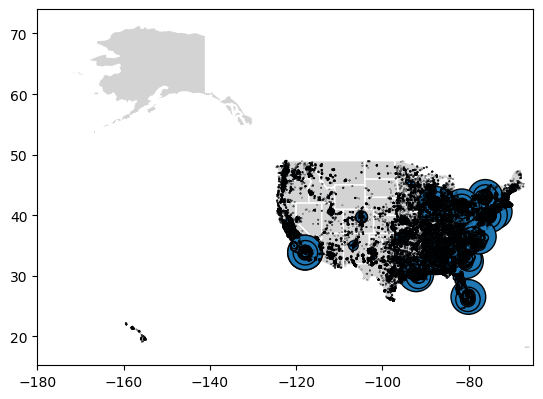

In [45]:
#mapped incident counts by city

from matplotlib.pyplot import figure

united_states = GeoDataFrame.from_file('shapefiles/state_shapefiles/')
#north_america.plot(color='lightgrey')

axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


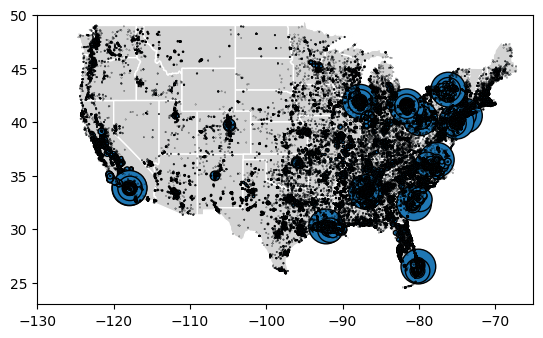

In [46]:
#mapped incident counts by city, zoomed into continental US

united_states = GeoDataFrame.from_file('shapefiles/state_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


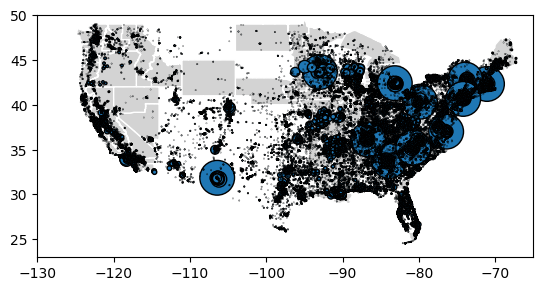

In [47]:
#mapped incident counts by congressional districts

united_states = GeoDataFrame.from_file('shapefiles/congressional_district_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_cong['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


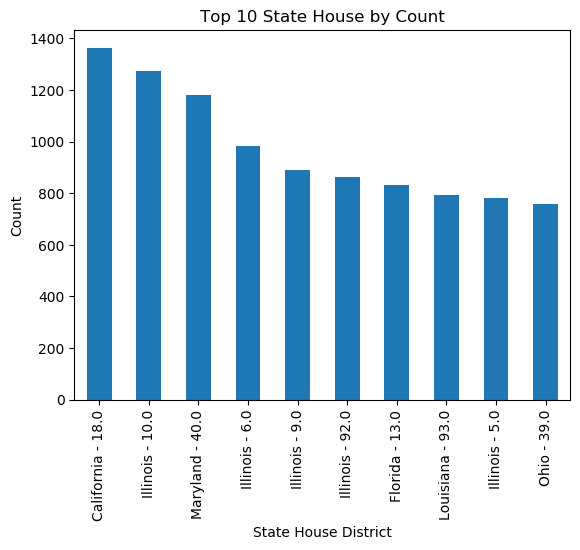

In [48]:
df_no_nans = df.dropna(subset=['state_house_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_house_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_house_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_house_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State House by Count')
plt.xlabel('State House District')
plt.ylabel('Count')

# Show the plot
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


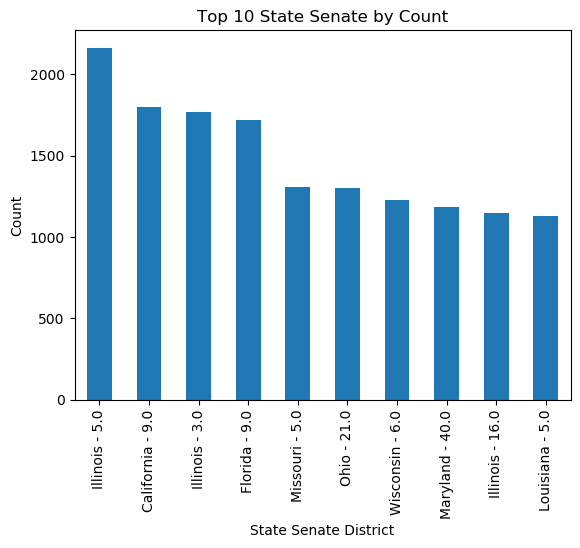

In [49]:
df_no_nans = df.dropna(subset=['state_senate_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_senate_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_senate_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_senate_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State Senate by Count')
plt.xlabel('State Senate District')
plt.ylabel('Count')

# Show the plot
plt.show()

In [50]:
### Find the 10 most common words listed in the 'incident characteristics' column ###
### The regular expressions is used as a space delimiter, since some of the words ###
### are separated with spaces and others are separated with the "||" symbol ###

import re
from collections import Counter
import pandas as pd

df["incident_characteristics"] = df["incident_characteristics"].astype(str)

# create an empty Counter object
word_counts = Counter()

# loop through each row in the DataFrame
for index, row in df.iterrows():
    # split the "Incident_Characteristics" column into a list of words using a regular expression
    words = re.findall(r'\w+', row['incident_characteristics'])
    # update the Counter object with the words in this row
    word_counts.update(words)

# get the 10 most common words
most_common_words_10 = word_counts.most_common(10)

# print the results
print("The 10 most common words are:")
for word, count in most_common_words_10:
    print(f"{word}: {count}")

The 10 most common words are:
Shot: 135922
Wounded: 87297
Injured: 87297
Shooting: 72469
Incident: 69304
of: 67376
found: 66027
gun: 58757
suicide: 53041
or: 49806


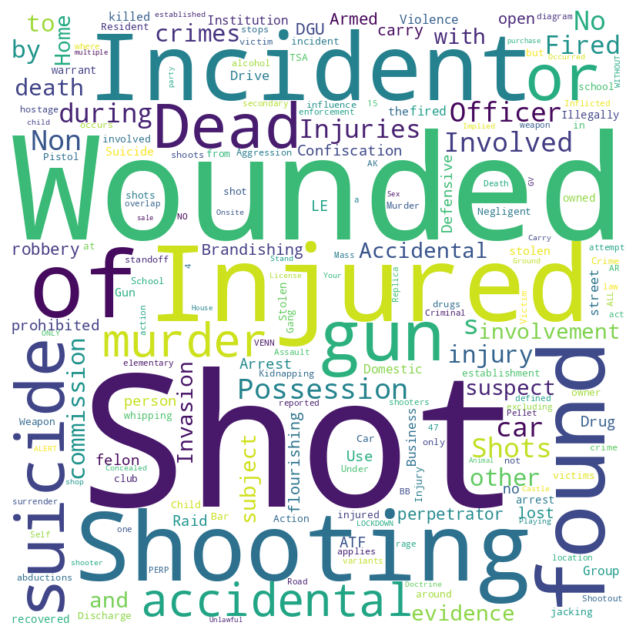

In [51]:
### Creating a word cloud of the most common words. Currently the count is 200, which ###
### feels like enough to get a good sense of the types of descriptive words used in ###
### the reports. ###

most_common_words_200 = word_counts.most_common(200)
most_common_words_dict = dict(most_common_words_200)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(most_common_words_dict)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [52]:
statement="SELECT year(date) as year, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date) ORDER BY year(date)"
year_count=pd.read_sql(statement, conn)
year_count

,year,incident_count,total_killed,total_injured
0,2013.0,266,299.0,937.0
1,2014.0,49668,12147.0,22255.0
2,2015.0,51147,12839.0,26036.0
3,2016.0,52637,12591.0,27589.0
4,2017.0,56234,14446.0,28581.0
5,2018.0,10394,2807.0,4786.0
6,NaN,27441,NaN,NaN


In [53]:
## Show the five deadliest shootings 
## Note: The dataset does not include the Las Vegas shooting that occured October 1st, 2017, which took the lives of 60 people.
statement="SELECT * FROM ads508.gun_violence ORDER BY n_killed desc LIMIT 10"
top_killed=pd.read_sql(statement, conn)
top_killed.head(5)

,id,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,...,target_class,n_total,region,year,group_democrat,group_republican,suspect_age,suspect_age_value,suspect_rel,suspect_age_group
0,108525,577157,2016-06-12,Florida,Orlando,1912 S Orange Avenue,50,53,http://www.gunviolencearchive.org/incident/577157,https://www.reuters.com/article/us-orlando-sho...,...,None,None,0::Killed||1::Killed||2::Killed||3::Killed||4:...,NaN,NaN,47.0,12.0,1.0,103,South Atlantic
1,184300,980577,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20,http://www.gunviolencearchive.org/incident/980577,http://abc7.com/full-list-of-texas-church-shoo...,...,None,None,0::Annabelle Renee Pomeroy||1::Emily Garcia||2...,NaN,NaN,NaN,NaN,44.0,21.0,1
2,219859,1049217,2018-02-14,Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17,http://www.gunviolencearchive.org/incident/104...,http://www.orlandosentinel.com/news/fl-florida...,...,None,None,"""0::Scott Beigel||1::Martin Duque Anguiano||2:...",NaN,NaN,NaN,NaN,NaN,96.0,29.0
3,56849,456893,2015-12-02,California,San Bernardino,1365 South Waterman Avenue,16,19,http://www.gunviolencearchive.org/incident/456893,http://www.latimes.com/local/lanow/la-me-ln-sa...,...,None,None,None,NaN,NaN,NaN,NaN,NaN,None,None
4,92834,423223,2015-10-01,Oregon,Roseburg,1140 Umpqua College Rd,10,9,http://www.gunviolencearchive.org/incident/423223,http://www.kval.com/news/local/Nine-wounded-vi...,...,None,None,7.0,4.0,1.0,19.0,NaN,2015.0,1,0


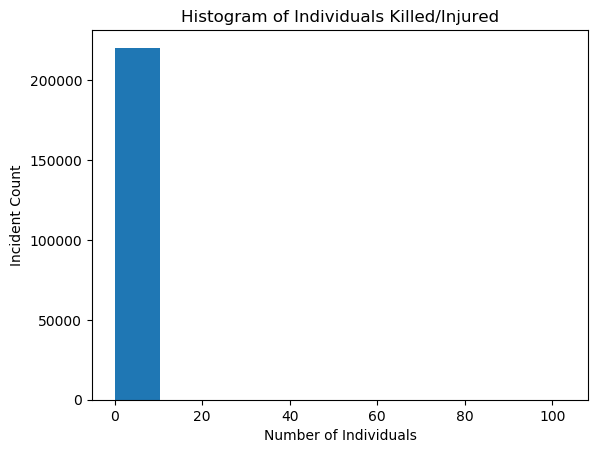

In [54]:
import matplotlib.ticker as mticker
plt.clf()
plt.hist(df['n_total'])
plt.xlabel('Number of Individuals')
plt.ylabel('Incident Count')
plt.title('Histogram of Individuals Killed/Injured')
plt.show()

In [55]:
statement="SELECT count(*) as count FROM ads508.gun_violence WHERE n_injured=0 and n_killed=0"
no_injury=pd.read_sql(statement, conn)
no_injury

,count
0,88666


In [56]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df_selected_columns = df[['incident_id', 'date','year','state', 'city_or_county', 'congressional_district']]
df_selected_columns.head()

,incident_id,date,year,state,city_or_county,congressional_district
0,461105,2013-01-01,2013,Pennsylvania,Mckeesport,14.0
1,481268,2013-10-21,2013,Pennsylvania,Pittsburgh (Homewood),14.0
2,460726,2013-01-01,2013,California,Hawthorne,43.0
3,486109,2013-05-10,2013,California,Los Angeles,43.0
4,492950,2013-11-03,2013,California,Los Angeles,43.0


In [57]:
df_congress = pd.read_csv("{}/Congress_2013-2018.csv".format(s3_path_3))
df_congress.head()

,id,name,sort_name,email,twitter,facebook,group,group_id,state,district,chamber,year,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area
0,cfc9cc09-a33a-42d9-89c3-14effb20b8b0,Aaron Schock,"Schock, Aaron",NaN,AaronSchock,RepAaronSchock,Republican,republican,IL,18,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q302659,Q29468,Q3032529
1,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"Schiff, Adam",NaN,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,CA,28,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552,Q5020000
2,159bbcc4-afee-4a5d-9097-e2be4d8ca9c7,Adam Kinzinger,"Kinzinger, Adam",NaN,RepKinzinger,RepKinzinger,Republican,republican,IL,16,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q349955,Q29468,Q3477977
3,fed6fe02-7935-4711-a190-fed9abd0a5ae,Adam Smith,"Smith, Adam",NaN,RepAdamSmith,RepAdamSmith,Democrat,democrat,WA,9,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350916,Q29552,Q7971571
4,4eb41831-ea19-4833-86f9-6f6c3ba72451,Adrian Smith,"Smith, Adrian",NaN,RepAdrianSmith,NaN,Republican,republican,NE,3,House of Representatives,2013,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q373443,Q29468,Q6984664


In [58]:
df_states = pd.read_csv("{}/state_abbrev_map.csv".format(s3_path_2))
df_states.head()

,state,abbrev,code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [59]:
merged_df = df_congress.merge(df_states, left_on='state', right_on='code')
merged_df.drop(columns=['id', 'name', 'sort_name', 'email', 'twitter', 'facebook',
                        'group_id', 'chamber', 'start_date', 'state_x', 
                        'end_date', 'image', 'gender', 'wikidata', 'wikidata_group',
                        'wikidata_area', 'abbrev', 'code'], inplace=True)
merged_df.rename(columns={'state_y': 'state', 'district': 'congressional_district'}, inplace=True)
# Dropping duplicates to account for rep changes mid-term. Party always stays the same
# but is counted twice in the same year because 2 different people occupied the position
# that year (this is often the case when the congressperson gets an appointment to a higher
# office). 
merged_df = merged_df.drop_duplicates()
merged_df.head()

,group,congressional_district,year,state
0,Republican,18,2013,Illinois
1,Republican,16,2013,Illinois
2,Democrat,11,2013,Illinois
3,Democrat,1,2013,Illinois
4,Democrat,10,2013,Illinois


In [60]:
print(df['congressional_district'].dtype)
print(merged_df['congressional_district'].dtype)

float64
int64


In [61]:
merged_df['congressional_district'] = merged_df['congressional_district'].astype(float)
df = df.merge(merged_df, on=['state', 'congressional_district', 'year'])

In [62]:
df_selected_columns = df[['incident_id', 'state', 'city_or_county', 'congressional_district', 'group', 'year']]
df_selected_columns.head()

,incident_id,state,city_or_county,congressional_district,group,year
0,461105,Pennsylvania,Mckeesport,14.0,Democrat,2013
1,481268,Pennsylvania,Pittsburgh (Homewood),14.0,Democrat,2013
2,460726,California,Hawthorne,43.0,Democrat,2013
3,486109,California,Los Angeles,43.0,Democrat,2013
4,492950,California,Los Angeles,43.0,Democrat,2013


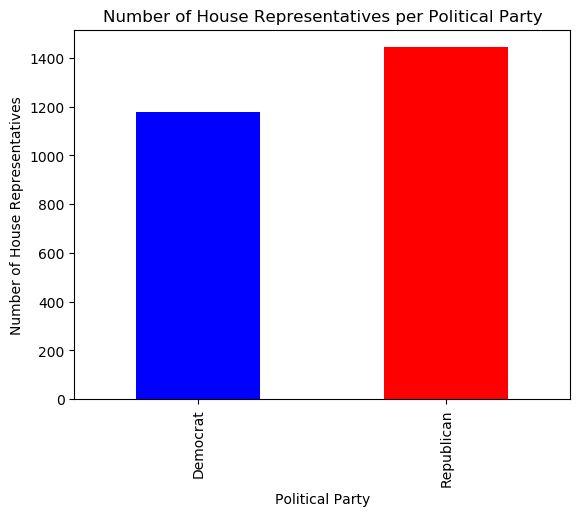

In [63]:
party_counts = merged_df['group'].value_counts()

party_counts.sort_index(inplace=True)

# Create a dictionary to specify the colors for each party
color_dict = {'Democrat': 'blue', 'Republican': 'red'}

# Create a bar chart using the party_counts and color dictionary
party_counts.plot(kind='bar', color=[color_dict.get(x) for x in party_counts.index])

# Set the title and labels for the bar chart
plt.title('Number of House Representatives per Political Party')
plt.xlabel('Political Party')
plt.ylabel('Number of House Representatives')

# Display the bar chart
plt.show()

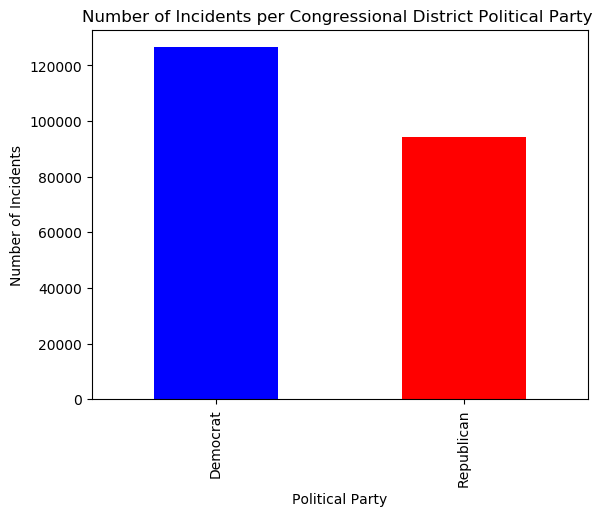

In [64]:
# Setting up a bar chart to show the amount of incident ids
# per political party
grouped_data = df.groupby('group')['incident_id'].count()

grouped_data.sort_index(inplace = True)

color_dict = {'Democrat': 'blue', 'Republican': 'red'}
grouped_data.plot(kind='bar', color=[color_dict.get(x) for x in grouped_data.index])

# Set the title and labels for the bar chart
plt.title('Number of Incidents per Congressional District Political Party ')
plt.xlabel('Political Party')
plt.ylabel('Number of Incidents')

# Display the bar chart
plt.show()